#### Importing the Required Python Libraries

In [2]:
import pandas as pd
import plotly.express as px
from fbprophet import Prophet
import plotly.io as pio
pio.renderers.default = 'colab'
import yfinance as yf
import itertools
import numpy as np
from fbprophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import ParameterGrid

**Importing Data from Yahoo Finance**

In [3]:
def data_import(ticker, historical_data):
  tickers = [ticker]
  stock_data = pd.DataFrame(columns = tickers)
  data = yf.Ticker(ticker)
  stock_data[ticker] = data.history(period = historical_data)['Close']
  stock_data.reset_index(inplace = True)
  fbp_df = stock_data.rename(columns={'Date':'ds', ticker:'y'})
  return fbp_df

#### Defining the evaluation metric

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  mape = round((np.mean(np.abs((y_true - y_pred) / y_true)) * 100),4)
  return mape

#### Hyperparameter Optimization using Grid Search

In [5]:
def hyp_param_tune(hyperparameter_tuning = False):
  if hyperparameter_tuning == True:
    param_grid={
        "daily_seasonality": [False],
        "weekly_seasonality":[False],
        'seasonality_mode':('multiplicative','additive'),
        'changepoint_prior_scale': [0.001, 0.005,0.01, 0.03, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5], # to give higher value to prior trend
        'seasonality_prior_scale': [0.01, 0.1, 0.5, 1, 3, 5, 10], # to control the flexibility of seasonality components
    }
    # Generate all combination of parameters
    all_params= [
                dict(zip(param_grid.keys(), v))
                for v in itertools.product(*param_grid.values())
    ]
    
    grid = ParameterGrid(param_grid)
    count = 0
    for p in grid:
        count = count+1
    return grid, count
  else:
    count = "default parameters used"
    return None, count

#### Training, Evaluating and Predicting the priceusing the best parameters

In [6]:
def stock_price_prediction(ticker, historical_data, prediction_period, test_train_split, hyperparameter_tuning = False):
  data1 = data_import(ticker, historical_data)
  split = int(len(data1)*test_train_split)
  train_data = data1[:split]
  test_data = data1[split:]

  if hyperparameter_tuning == True:
    params, count = hyp_param_tune(hyperparameter_tuning)
    model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
    i = 1
    for p in params:
      model = Prophet(**p)
      model.fit(train_data)
      val_forecast = model.make_future_dataframe(periods = len(test_data), freq='D',include_history = False)
      forecast = model.predict(val_forecast)
      valid_data = forecast['yhat']
      MAPE = mean_absolute_percentage_error(test_data['y'],abs(valid_data))
      print('Printing {} of {} with MAPE {}'.format(i, count, MAPE))
      model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
      i += 1
    
    parameters = model_parameters.sort_values(by=['MAPE'])
    parameters = parameters.reset_index(drop=True)
    best_param = parameters['Parameters'][0]

    final_model = Prophet(**best_param)
    final_model.fit(data1)
    future = final_model.make_future_dataframe(periods = prediction_period)
    future_forecast = final_model.predict(future)
    fig = final_model.plot(future_forecast, xlabel= 'Date', ylabel= ticker)
    
    return future_forecast,print('Lowest MAPE is {} for Parameters {}'.format(parameters['MAPE'][0], best_param)), fig
  
  else: 
    model = Prophet(daily_seasonality = False, weekly_seasonality = False)
    model.fit(data1)
    future = model.make_future_dataframe(periods = prediction_period)
    future_forecast = model.predict(future)
    fig = model.plot(future_forecast, xlabel= 'Date', ylabel= ticker)
    return future_forecast, fig

Printing 1 of 140 with MAPE 15.5847
Printing 2 of 140 with MAPE 14.0245
Printing 3 of 140 with MAPE 14.9714
Printing 4 of 140 with MAPE 14.1355
Printing 5 of 140 with MAPE 14.5288
Printing 6 of 140 with MAPE 15.0738
Printing 7 of 140 with MAPE 14.2286
Printing 8 of 140 with MAPE 14.6972
Printing 9 of 140 with MAPE 14.5711
Printing 10 of 140 with MAPE 13.8209
Printing 11 of 140 with MAPE 14.2218
Printing 12 of 140 with MAPE 14.4868
Printing 13 of 140 with MAPE 13.8145
Printing 14 of 140 with MAPE 14.2946
Printing 15 of 140 with MAPE 5.4638
Printing 16 of 140 with MAPE 4.0014
Printing 17 of 140 with MAPE 4.3954
Printing 18 of 140 with MAPE 4.466
Printing 19 of 140 with MAPE 4.2585
Printing 20 of 140 with MAPE 4.2363
Printing 21 of 140 with MAPE 4.4207
Printing 22 of 140 with MAPE 6.3879
Printing 23 of 140 with MAPE 5.8155
Printing 24 of 140 with MAPE 6.0323
Printing 25 of 140 with MAPE 6.1446
Printing 26 of 140 with MAPE 6.2304
Printing 27 of 140 with MAPE 5.9222
Printing 28 of 140 with 

(            ds       trend  ...  multiplicative_terms_upper        yhat
 0   2018-08-21  150.940431  ...                         0.0  171.736385
 1   2018-08-22  150.866214  ...                         0.0  172.327128
 2   2018-08-23  150.791997  ...                         0.0  172.882328
 3   2018-08-24  150.717780  ...                         0.0  173.390744
 4   2018-08-27  150.495129  ...                         0.0  174.531620
 ..         ...         ...  ...                         ...         ...
 871 2021-12-14  381.523579  ...                         0.0  376.610263
 872 2021-12-15  381.821973  ...                         0.0  376.413771
 873 2021-12-16  382.120367  ...                         0.0  376.203867
 874 2021-12-17  382.418760  ...                         0.0  375.985303
 875 2021-12-18  382.717154  ...                         0.0  375.763095
 
 [876 rows x 16 columns], None, <Figure size 720x432 with 1 Axes>)

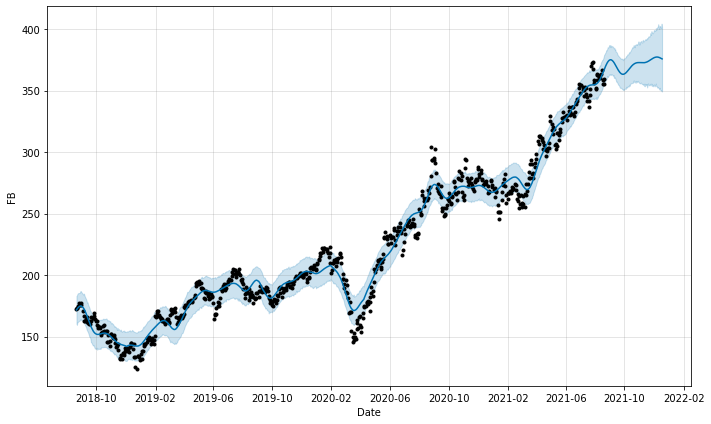

In [7]:
stock_price_prediction("FB", "3y", 120, 0.9,True)